In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from preprocessing import *
from scipy import stats as st

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering


In [2]:
# The 19 activities are:
# sitting (0): index 0,
# standing (1),
# lying on back and on right side (2 and 3),
# ascending and descending stairs (4 and 5),
# standing in an elevator still (6)
# and moving around in an elevator (7),
# walking in a parking lot (8),
# walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (9 and 10),
# running on a treadmill with a speed of 8 km/h (11),
# exercising on a stepper (12),
# exercising on a cross trainer (13),
# cycling on an exercise bike in horizontal and vertical positions (14 and 15),
# rowing (16),
# jumping (17),
# and playing basketball (18): index 18

activities = [0, 2, 3, 1, 8, 4, 14, 15, 14, 15, 1, 8, 11, 1, 12, 18, 5]
durations = [10, 5, 7, 3, 30, 8, 25, 25, 25, 20, 10, 30, 30, 4, 40, 80, 8]
person = 1

time_series, labels = get_daily_sports_timeseries('.\\Data\\Daily Sports Activities\\', person, activities, durations)
print(time_series.shape)
print(labels.shape)

(45, 45000)
(45000,)


In [3]:
windowLength = 75
overlapPercent = 0.0
activity_names = ['sitting',
                 'standing',
                 'lying on back',
                 'lying on side',
                 'ascending stairs',
                 'descending stairs',
                 'standing in elevator',
                 'moving in elevator',
                 'walking in lot',
                 'walking on treadmill flat'
                 'walking on treadmill incline',
                 'running on treadmill',
                 'exercising on stepper',
                 'exercising on cross trainer',
                 'cycling on bike horizontal',
                 'cycling on bike vertical',
                 'rowing',
                 'jumping',
                 'basketball']


start = 0
subsequences = []
subsequence_labels = []

while start+windowLength < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+windowLength])[0][0])    
    subsequence = time_series[:,start:start+windowLength]
    start = start+windowLength - int(overlapPercent*windowLength)
    subsequences.append(subsequence)

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
print(len(subsequences))
print(len(subsequence_labels))

599
599


In [4]:
def loss_fn(recon_z, x):
    BCE = F.mse_loss(recon_z, x)
    return BCE

def get_dataloader(data, batch_size, num_workers=0, data_transforms=None):
    if data_transforms is None:
        data_transforms = transforms.ToTensor()
        
    data_tensor = torch.from_numpy(data)
    
    data_loader = DataLoader(dataset=data_tensor, 
                             batch_size=batch_size, 
                             num_workers=num_workers)
    
    return data_loader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_loader = get_dataloader(data=subsequences,
                          batch_size=50,
                          num_workers=2,
                          data_transforms=None)

cuda


In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input, size1=32, size2=5):
        return input.view(input.size(0), size1, size2)
    
class Autoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.clustering_space=None
        
        self.encoder = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(75, 60),
#             nn.LeakyReLU(0.1),
#             nn.Linear(60, 45),
#             nn.LeakyReLU(0.1),
#             nn.Linear(45, 30),
#             nn.LeakyReLU(0.1),
#             nn.Linear(2000, 1500),
#             nn.LeakyReLU(0.1)
            nn.Conv1d(45, 45, 6, stride=4), # increase chan
            nn.LeakyReLU(0.1),
            nn.Conv1d(45, 45, 5, stride=3),
            nn.LeakyReLU(0.1),
            nn.Conv1d(45, 45, 4, stride=2),
            nn.LeakyReLU(0.1),
#             nn.Conv1d(16, 32, 3, stride=2),
#             nn.LeakyReLU(0.1),
            #nn.Flatten()
        )
        
        #self.fc1 = nn.Linear(2925, 2200)
        #self.fc2 = nn.Linear(2200, 1500)
        #self.fc3 = nn.Linear(1500, 2200)
        #self.fc4 = nn.Linear(2200, 2925)
        
        self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(1, 1, 3, stride=1),
#             nn.LeakyReLU(0.1),
#             nn.ConvTranspose1d(1, 1, 3, stride=1),
#             nn.LeakyReLU(0.1),
#             nn.ConvTranspose1d(1, 1, 5, stride=2,output_padding=1),
#             nn.LeakyReLU(0.1),
#             nn.ConvTranspose1d(1, 1, 5, stride=2),
#             nn.LeakyReLU(0.1)
#             nn.Linear(30, 45),
#             nn.LeakyReLU(0.1),
#             nn.Linear(45, 60),
#             nn.LeakyReLU(0.1),
#             nn.Linear(60, 75),
#             nn.LeakyReLU(0.1),
#             nn.Linear(3000, 3375),
#             nn.LeakyReLU(0.1),
            #UnFlatten(),
            nn.ConvTranspose1d(45, 45, 4, stride=2),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(45, 45, 5, stride=3),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(45, 45, 6, stride=4),
            nn.LeakyReLU(0.1),
            nn.Upsample(size=75, mode='nearest')
#             nn.ConvTranspose1d(4, 1, 5, stride=2),
#             nn.LeakyReLU(0.1),
        )
        
        
    def encode(self, x):
        h = self.encoder(x)
        #h = self.fc1(h)
        return h
    
    def decode(self, z):
        #z = self.fc3(z)
        #z = self.fc4(z)
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        z = self.encode(x)
        #z = self.fc2(z)
        z = self.decode(z)
        return z

In [6]:
model = Autoencoder()
model = model.double()

criterion = loss_fn
optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-4)

In [12]:
dataiter = iter(data_loader)
data = dataiter.next()
features = data
print(features.shape)

# Point to training loop video
num_epochs = 300
outputs = []
for epoch in range(num_epochs):
    for ts in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(ts.double())
        loss = criterion(recon, ts)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, ts, recon))

torch.Size([50, 45, 75])
Epoch:1, Loss:7.1055
Epoch:2, Loss:7.1190
Epoch:3, Loss:7.1023
Epoch:4, Loss:7.1053
Epoch:5, Loss:7.0984
Epoch:6, Loss:7.0971
Epoch:7, Loss:7.0893
Epoch:8, Loss:7.1007
Epoch:9, Loss:7.0708
Epoch:10, Loss:7.1006
Epoch:11, Loss:7.0625
Epoch:12, Loss:7.0867
Epoch:13, Loss:7.0605
Epoch:14, Loss:7.0631
Epoch:15, Loss:7.0567
Epoch:16, Loss:7.0574
Epoch:17, Loss:7.0424
Epoch:18, Loss:7.0580
Epoch:19, Loss:7.0276
Epoch:20, Loss:7.0559
Epoch:21, Loss:7.0234
Epoch:22, Loss:7.0359
Epoch:23, Loss:7.0209
Epoch:24, Loss:7.0217
Epoch:25, Loss:7.0124
Epoch:26, Loss:7.0161
Epoch:27, Loss:7.0027
Epoch:28, Loss:7.0118
Epoch:29, Loss:6.9926
Epoch:30, Loss:6.9980
Epoch:31, Loss:6.9905
Epoch:32, Loss:6.9820
Epoch:33, Loss:6.9891
Epoch:34, Loss:6.9704
Epoch:35, Loss:6.9842
Epoch:36, Loss:6.9661
Epoch:37, Loss:6.9751
Epoch:38, Loss:6.9604
Epoch:39, Loss:6.9674
Epoch:40, Loss:6.9493
Epoch:41, Loss:6.9612
Epoch:42, Loss:6.9438
Epoch:43, Loss:6.9499
Epoch:44, Loss:6.9424
Epoch:45, Loss:6

In [13]:
clustering_output = []
for ts in data_loader:
    recon = model.encode((ts.double()))
    clustering_output.append( recon.detach().numpy() ) 
    
print(len(clustering_output))
clustering_output = [item for sublist in clustering_output for item in sublist]

12


In [14]:
clustering_output = np.asarray(clustering_output)
print(clustering_output.shape)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)


(599, 45, 1)


In [15]:
X_embedded = TSNE(n_components=2).fit_transform(clustering_output_f)
print(X_embedded.shape)
print(labels.shape)

(599, 2)
(45000,)


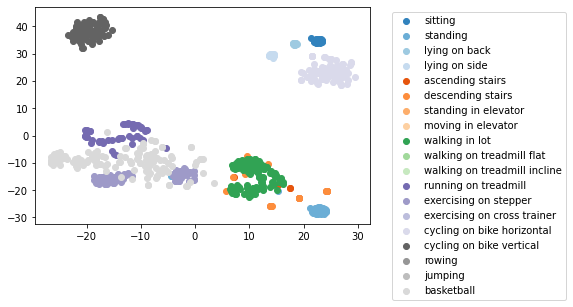

In [16]:
cmap = plt.get_cmap('tab20c')
activity_names = ['sitting',
                 'standing',
                 'lying on back',
                 'lying on side',
                 'ascending stairs',
                 'descending stairs',
                 'standing in elevator',
                 'moving in elevator',
                 'walking in lot',
                 'walking on treadmill flat',
                 'walking on treadmill incline',
                 'running on treadmill',
                 'exercising on stepper',
                 'exercising on cross trainer',
                 'cycling on bike horizontal',
                 'cycling on bike vertical',
                 'rowing',
                 'jumping',
                 'basketball']


l = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[la])

plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))

In [49]:
# here we need to mention the number of clusters
# otherwise the result will be a single cluster
# containing all the data
clustering = AgglomerativeClustering(n_clusters = 12).fit(clustering_output_f)
 
# print the class labels
print(clustering.labels_)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11
 11  5  5  5  5  5  5  5  5  5  5  5  5  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10  8  8  8  8  8  8  8  8  8  8  8  8 10  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8 10  8  8  8  8  8  8  8  8  8  8  8  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [72]:
len(subsequence_labels)

599

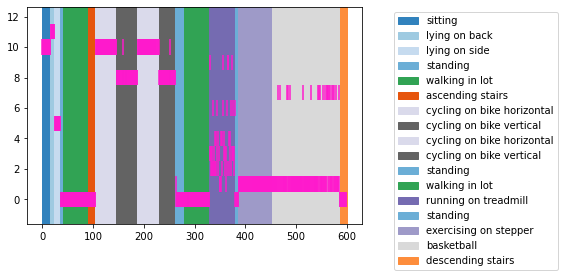

In [84]:

positions = np.arange(len(clustering.labels_))[:,np.newaxis]
plt.eventplot(positions, lineoffsets=clustering.labels_, color = [(1.0,0.1,0.8)])
vlines = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
#for vline in vlines:
#    plt.axvline(x = vline, color = 'b', label = 'axvline - full height', linestyle=':', mfc='b')

start = 0
for i, activity in enumerate(activities):
    if i == len(activities):
        continue
    if i == len(activities)-1:
        end = len(subsequence_labels)
    else:
        end = vlines[i]
    plt.axvspan(start, end, alpha=1.0, color=slicedCM[activity], label=activity_names[activity])
    plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))
    start = end
plt.show()

In [89]:
# The 19 activities are:
# sitting (0): index 0,
# standing (1),
# lying on back and on right side (2 and 3),
# ascending and descending stairs (4 and 5),
# standing in an elevator still (6)
# and moving around in an elevator (7),
# walking in a parking lot (8),
# walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (9 and 10),
# running on a treadmill with a speed of 8 km/h (11),
# exercising on a stepper (12),
# exercising on a cross trainer (13),
# cycling on an exercise bike in horizontal and vertical positions (14 and 15),
# rowing (16),
# jumping (17),
# and playing basketball (18): index 18
activities = [0, 2, 3, 1, 8, 4, 14, 15, 14, 15, 1, 8, 11, 1, 12, 18, 5]
durations = [10, 5, 7, 3, 30, 8, 25, 25, 25, 20, 10, 30, 30, 4, 40, 80, 8]


10199


In [20]:
np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]

array([ 16,  24,  36,  41,  91, 104, 146, 187, 229, 262, 279, 329, 379,
       386, 452, 586], dtype=int64)

In [91]:
subsequence_labels[:-1]!= subsequence_labels[1:]

array([False, False, False, ..., False, False, False])

In [83]:
st.mode(labels[start:start+windowLength])[0][0]

5

In [101]:
subsequence_labels[:1201]

array([0, 0, 0, ..., 2, 2, 3])

In [32]:
[0, activities, 1]

[0, [0, 2, 3, 1, 8, 4, 14, 15, 14, 15, 1, 8, 11, 1, 12, 18, 5], 1]

In [48]:
unique, counts = np.unique(labels, return_counts=True)
print(len(unique), counts)

12 [ 1250  2125   625   875  1000  1000  7500  3750  5000  6250  5625 10000]


In [ ]:
durations = [10, 5, 7, 3, 30, 8, 25, 25, 25, 20, 10, 30, 30, 4, 40, 80, 8]
activities = [0, 2, 3, 1, 8,  4, 14, 15, 14, 15, 1,   8, 11, 1, 12, 18, 5]
durations = [10, 5, 7, 3, 30, 8, 25, 25, 25, 20, 10, 30, 30, 4, 40, 80, 8]


In [105]:
clips = np.random.randint(low=0, high=60, size=20)

In [106]:
clips

array([16, 30, 15,  3, 19, 52, 52, 45,  8, 30, 33, 55, 14, 12, 22, 22, 55,
        0, 38,  8])